**Set up Google directory**

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import os
workdir_path = '/content/drive/My Drive/Project1'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

**Import necessary libraries and load the files**

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [50]:
#Load 2020 file and a quick look

df = pd.read_csv('survey_results_public.csv')
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,NaN,Straight / Heterosexual,No,"No, not at all",NaN,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,NaN,NaN,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,NaN,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Once a decade,NaN,NaN,No,NaN,NaN,NaN,Stack Overflow (public Q&A for anyone who codes),NaN,Linux-based,NaN,NaN,NaN,NaN,NaN,Yes,"Yes, somewhat",A few times per month or weekly,Daily or almost daily,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,White or of European descent,Man,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not at all important/not necessary,Curious about other opportunities;Wanting to w...,NaN,Once a year,Not sure,Yes,Yes,Occasionally: 1-2 days per quarter but less th...,NaN,NaN,Stack Overflow (public Q&A for anyone who code...,NaN,Lin

In [51]:
df.shape

(64461, 61)

In [52]:
#Load 2015 file and a quick look

df2 = pd.read_csv('2015 Stack Overflow Developer Survey Responses.csv', header=1)
df2.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,108,121,196,197,198) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Country,Age,Gender,Tabs or Spaces,Years IT / Programming Experience,Occupation,Desktop Operating System,Desktop Operating System: write-in,Current Lang & Tech: Android,Current Lang & Tech: Arduino,Current Lang & Tech: AngularJS,Current Lang & Tech: C,Current Lang & Tech: C++,Current Lang & Tech: C++11,Current Lang & Tech: C#,Current Lang & Tech: Cassandra,Current Lang & Tech: CoffeeScript,Current Lang & Tech: Cordova,Current Lang & Tech: Clojure,Current Lang & Tech: Cloud,Current Lang & Tech: Dart,Current Lang & Tech: F#,Current Lang & Tech: Go,Current Lang & Tech: Hadoop,Current Lang & Tech: Haskell,Current Lang & Tech: iOS,Current Lang & Tech: Java,Current Lang & Tech: JavaScript,Current Lang & Tech: LAMP,Current Lang & Tech: Matlab,Current Lang & Tech: MongoDB,Current Lang & Tech: Node.js,Current Lang & Tech: Objective-C,Current Lang & Tech: Perl,Current Lang & Tech: PHP,Current Lang & Tech: Python,Current Lang & Tech: R,Current Lang & Tech: Redis,Current Lang & Tech: Ruby,Current Lang & Tech: Rust,...,Why try Stack Overflow Careers: Showcase Stack Overflow activity,Why try Stack Overflow Careers: Jobs are on Stack Overflow,Why try Stack Overflow Careers: Other,How many caffeinated beverages per day?,How many hours programming as hobby per week?,How frequently land on or read Stack Overflow,Preferred text editor,Preferred text editor: write-in,Prefered IDE theme,Source control used: Git,Source control used: Mercurial,Source control used: SVN,Source control used: CVS,Source control used: Perforce,Source control used: TFS,Source control used: DCVS,Source control used: Bitkeeper,Source control used: Legacy / Custom,Source control used: I don't use source control,Source control used: write-in,Prefered Source Control,Prefered Source Control: write-in,Why use Stack Overflow: Help for job,Why use Stack Overflow: To give help,Why use Stack Overflow: Can't do job without it,Why use Stack Overflow: Maintain online presence,Why use Stack Overflow: Demonstrate expertise,Why use Stack Overflow: Communicate with others,Why use Stack Overflow: Receive help on personal projects,Why use Stack Overflow: Love to learn,Why use Stack Overflow: I don't use Stack Overflow,How often are Stack Overflow's answers helpful,Why answer: Help a programmer in need,Why answer: Help future programmers,Why answer: Demonstrate expertise,Why answer: Self promotion,Why answer: Sense of responsibility to developers,Why answer: No idea,Why answer: I don't answer and I don't want to,Why answer: I don't answer but I want to
0,Croatia,25-29,Male,Tabs,2 - 5 years,Back-end web developer,Ubuntu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Java,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,To showcase my Stack Overflow activity,Because the jobs ads are right there on Stack ...,NaN,0,5-10 hours per week,Multipleætimes a day,Sublime Text,NaN,Dark,NaN,Mercurial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mercurial,NaN,To get help for my job,To give help to others,Because I can't do my job without it,NaN,To demonstrate that I'm good at what I do,NaN,To receive help onæmy personal projects,Because I love to learn,NaN,Usually,NaN,NaN,It feels good to demonstrate my expertise.,Demonstrating my expertise will benefit me,I feel a sense of responsibility to the develo...,NaN,NaN,NaN
1,France,20-24,Male,Spaces,1 - 2 years,Back-end web developer,Windows 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,2-5 hours per week,Once a day,NaN,Visual Studio 2013,Light,Git,NaN,NaN,NaN,NaN,TFS,NaN,NaN,NaN,NaN,NaN,TFS,NaN,To get help for my job,To give help to others,NaN,NaN,NaN,NaN,To receive help onæmy personal projects,NaN,NaN,Usually,NaN,My answer will help lots of people who have th...,It feels good to demonstrate my expertise.,NaN,NaN,NaN,NaN,NaN
2,India,20-24,Male,Tabs,1 - 2 years,Back-end web developer,Windows 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C#,NaN,NaN,N

In [53]:
df2.shape

(26086, 222)

##**Assess and clean the data**

**First, df (2020 survey)**

In [54]:
#Quick look at the columns

df.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq',
       'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc',
       'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith',
       'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors',
       'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith',
       'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch',
       'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms',
       'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites',
       'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear',
       'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount',
       'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength',
       'Trans', 'UndergradMajor', 'WebframeDesireNextYear',
  

In [55]:
#Select only the important columns to our analysis and check null values

new_df = df[['Age', 'ConvertedComp', 	'YearsCodePro', 'Country', 'EdLevel']]
new_df.isnull().mean()

Age              0.294985
ConvertedComp    0.460821
YearsCodePro     0.280976
Country          0.006035
EdLevel          0.109058
dtype: float64

We can see that we have more missing values in the most important column to our analysis, ConvertedComp. This way, it doesn't seem to be a good idea fill in almost 50% of our values with the mean or other statistic about the data - it can bias our results. The chosen approach is to drop missing values and keep only the original ones. 

In [56]:
#Drop missing values by ConvertedComp

new_df.dropna(subset=['ConvertedComp'],inplace=True)
new_df.isnull().mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Age              0.119692
ConvertedComp    0.000000
YearsCodePro     0.003884
Country          0.000000
EdLevel          0.016343
dtype: float64

After dropping missing values from ConvertedComp, the only variable with a high number of missing values is Age. Let's look into that for more details.

In [57]:
new_df["Age"].describe().apply(lambda x: format(x, 'f'))

count    30596.000000
mean        32.164388
std          8.616750
min          1.000000
25%         26.000000
50%         30.000000
75%         36.000000
max        279.000000
Name: Age, dtype: object

We can see from min and max values (1 - 279) that some data are inconsistent. Anyway, lets check if the mean value changes too much keeping only a different range of values - from 15 to 60.

In [58]:
new_df.query('Age < 60 & Age > 15').mean()

Age                  31.847022
ConvertedComp    102598.236034
dtype: float64

Since the Mean does not change too much, we are already going to fill in nan values with the mean.

In [59]:
new_df['Age'] = new_df['Age'].fillna(new_df['Age'].mean())
new_df['Age'].isnull().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0

In [60]:
#Tukey test on Age data to check min and max values to identify outliers

Q1 = new_df['Age'].quantile(0.25)
Q3 = new_df['Age'].quantile(0.75)

IQR = Q3 -Q1

Max = Q3 + 1.5*IQR
Min = Q1 - 1.5*IQR
print('Min value {} , Max value {}'.format(Min,Max))

Min value 15.0 , Max value 47.0


In [61]:
new_df[new_df['Age'] > 47]['Age'].count() / new_df['Age'].shape[0]

0.0555012084244447

In [62]:
new_df[new_df['Age'] > 60]['Age'].count() / new_df['Age'].shape[0]

0.006847738519967775

Since we still have a substantial percentage of data between 47 and 60, let's change the threshold to 60

In [63]:
new_df = new_df.query('Age < 60 & Age > 15')
new_df.Age.describe()

count    34448.000000
mean        31.885348
std          7.366108
min         16.000000
25%         27.000000
50%         31.000000
75%         35.000000
max         59.000000
Name: Age, dtype: float64

Looking at ConvertedComp - compensation in USD

In [64]:
new_df["ConvertedComp"].describe().apply(lambda x: format(x, 'f'))

count      34448.000000
mean      103198.940490
std       226385.268379
min            0.000000
25%        24515.500000
50%        53508.000000
75%        94600.000000
max      2000000.000000
Name: ConvertedComp, dtype: object

In [65]:
#Tukey rule for Outliers
Q1 = new_df['ConvertedComp'].quantile(0.25)
Q3 = new_df['ConvertedComp'].quantile(0.75)

IQR = Q3 -Q1

Max = Q3 + 1.5*IQR
Min = Q1 - 1.5*IQR
print('Min value {} , Max value {}'.format(Min,Max))

Min value -80611.25 , Max value 199726.75


In [66]:
#Quantity of values above 200000 (changed 199726 to 200000)

new_df[new_df['ConvertedComp'] > 200000]['ConvertedComp'].count()

2266

In [67]:
#Percentage of values above 350000

new_df[new_df['ConvertedComp'] > 350000].shape[0] / new_df['ConvertedComp'].shape[0]

0.04284718996748723

In order to keep our data of ConvertedComp closer to the range of tukey rule we are going to set out threshold to 350.000 (losing about 4% of that column)

In [68]:
new_df = new_df.query('ConvertedComp < 350000')
new_df.ConvertedComp.describe()

count     32949.000000
mean      62924.632189
std       53066.744267
min           0.000000
25%       23232.000000
50%       50806.000000
75%       86478.000000
max      349043.000000
Name: ConvertedComp, dtype: float64

Looking at YearsCodePro (years coding professionally)

In [69]:
new_df['YearsCodePro'].value_counts()

3                     3451
2                     3379
5                     2876
4                     2679
6                     2066
10                    1942
1                     1885
8                     1676
7                     1657
Less than 1 year      1406
12                    1086
15                    1067
20                     956
9                      926
11                     739
13                     674
14                     553
16                     457
25                     384
18                     367
17                     329
22                     311
19                     273
21                     265
23                     227
30                     215
24                     174
26                     128
27                     104
35                      87
28                      85
32                      65
34                      54
33                      51
31                      50
29                      47
38                      27
3

To keep only numerical values, lets transform "less than 1 year" to 1 year and
"more than 50 years" to 50

In [70]:
new_df['YearsCodePro'][new_df['YearsCodePro'] == 'Less than 1 year'] = 1
new_df['YearsCodePro'][new_df['YearsCodePro'] == 'More than 50 years'] = 50
new_df['YearsCodePro'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


3     3451
2     3379
5     2876
4     2679
6     2066
10    1942
1     1885
8     1676
7     1657
1     1406
12    1086
15    1067
20     956
9      926
11     739
13     674
14     553
16     457
25     384
18     367
17     329
22     311
19     273
21     265
23     227
30     215
24     174
26     128
27     104
35      87
28      85
32      65
34      54
33      51
31      50
29      47
38      27
36      27
40      25
37      19
39      10
42       7
41       4
45       3
43       3
50       2
46       1
44       1
47       1
Name: YearsCodePro, dtype: int64

In [71]:
#Since we have few percentage of missing, we'll drop them

new_df.dropna(subset=['YearsCodePro'], inplace=True)

In [72]:
#Changing the column to int

new_df['YearsCodePro'] = new_df['YearsCodePro'].astype('int')
new_df['YearsCodePro'].describe()

count    32821.000000
mean         8.260565
std          7.199562
min          1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max         50.000000
Name: YearsCodePro, dtype: float64

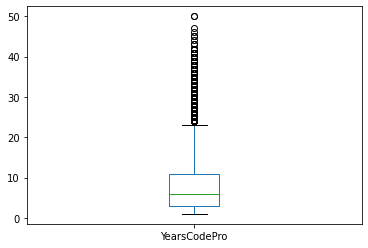

In [73]:
new_df['YearsCodePro'].plot(kind ='box')

In [74]:
#Tukey rule for outliers

Q1 = new_df['YearsCodePro'].quantile(0.25)
Q3 = new_df['YearsCodePro'].quantile(0.75)

IQR = Q3 -Q1

Max = Q3 + 1.5*IQR
Min = Q1 - 1.5*IQR
print('Min value {} , Max value {}'.format(Min,Max))

Min value -9.0 , Max value 23.0


In [75]:
np.sort(new_df[new_df['YearsCodePro'] > 25]['YearsCodePro'].unique())

array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 50])

After checking the above-listed values, we found a problem in YearsCodePro = 47, the Age is only 2 years higher than 47

In [76]:
new_df[new_df['YearsCodePro'] == 47]

,Age,ConvertedComp,YearsCodePro,Country,EdLevel
52606,49.0,0.0,47,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)"


In [77]:
#dropp 47

new_df = new_df[new_df.YearsCodePro != 47]
new_df.shape

(32820, 5)

In [78]:
#Numerical Data from df (2020 survey)

new_df.describe()

,Age,ConvertedComp,YearsCodePro
count,32820.000000,32820.000000,32820.000000
mean,31.834969,62999.763498,8.259385
std,7.368948,53084.304048,7.196495
min,16.000000,0.000000,1.000000
25%,26.600000,23301.000000,3.000000
50%,31.000000,50824.000000,6.000000
75%,35.000000,86478.000000,11.000000
max,59.000000,349043.000000,50.000000


Looking into "Country" data

In [79]:
new_df.Country.value_counts()

United States                       7379
India                               2613
United Kingdom                      2295
Germany                             2193
Canada                              1260
                                    ... 
Burkina Faso                           1
Niger                                  1
Yemen                                  1
Malawi                                 1
Saint Vincent and the Grenadines       1
Name: Country, Length: 159, dtype: int64

In [80]:
list_countries = list(new_df.Country.value_counts().loc[lambda x : x > 100].to_frame().index)
(new_df.shape[0] - new_df[new_df['Country'].isin(list_countries)].shape[0]) / new_df.shape[0]

0.06828153564899452

We are going to discard countries with less than 100 total of population, since it can bias a future model (few samplings to train)

In [81]:
new_df = new_df[new_df['Country'].isin(list_countries)]

Looking into EdLevel (Education data)

In [82]:
new_df['EdLevel'].isnull().sum()

499

In [83]:
#Dropping remaining missing values from new_df

new_df.dropna(subset=['EdLevel', 'Country'], inplace=True)

In [84]:
new_df['EdLevel'].value_counts(normalize=True)

Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          0.489328
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       0.257148
Some college/university study without earning a degree                                0.119049
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)    0.044182
Associate degree (A.A., A.S., etc.)                                                   0.034707
Other doctoral degree (Ph.D., Ed.D., etc.)                                            0.033610
Professional degree (JD, MD, etc.)                                                    0.013597
Primary/elementary school                                                             0.004255
I never completed any formal education                                                0.004122
Name: EdLevel, dtype: float64

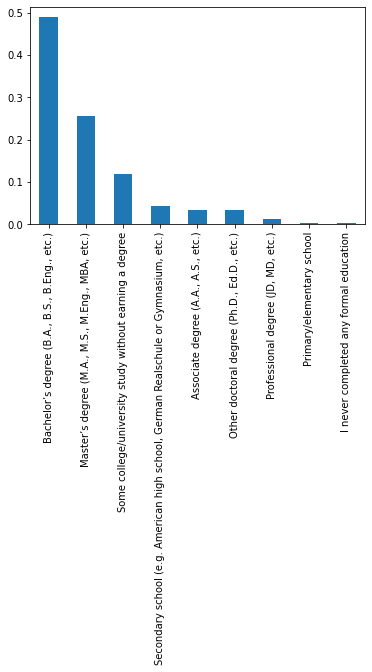

In [85]:
new_df['EdLevel'].value_counts(normalize=True).plot(kind='bar')

**Asses and clean df2 (2015 survey)**

In [86]:
df2.head()

,Country,Age,Gender,Tabs or Spaces,Years IT / Programming Experience,Occupation,Desktop Operating System,Desktop Operating System: write-in,Current Lang & Tech: Android,Current Lang & Tech: Arduino,Current Lang & Tech: AngularJS,Current Lang & Tech: C,Current Lang & Tech: C++,Current Lang & Tech: C++11,Current Lang & Tech: C#,Current Lang & Tech: Cassandra,Current Lang & Tech: CoffeeScript,Current Lang & Tech: Cordova,Current Lang & Tech: Clojure,Current Lang & Tech: Cloud,Current Lang & Tech: Dart,Current Lang & Tech: F#,Current Lang & Tech: Go,Current Lang & Tech: Hadoop,Current Lang & Tech: Haskell,Current Lang & Tech: iOS,Current Lang & Tech: Java,Current Lang & Tech: JavaScript,Current Lang & Tech: LAMP,Current Lang & Tech: Matlab,Current Lang & Tech: MongoDB,Current Lang & Tech: Node.js,Current Lang & Tech: Objective-C,Current Lang & Tech: Perl,Current Lang & Tech: PHP,Current Lang & Tech: Python,Current Lang & Tech: R,Current Lang & Tech: Redis,Current Lang & Tech: Ruby,Current Lang & Tech: Rust,...,Why try Stack Overflow Careers: Showcase Stack Overflow activity,Why try Stack Overflow Careers: Jobs are on Stack Overflow,Why try Stack Overflow Careers: Other,How many caffeinated beverages per day?,How many hours programming as hobby per week?,How frequently land on or read Stack Overflow,Preferred text editor,Preferred text editor: write-in,Prefered IDE theme,Source control used: Git,Source control used: Mercurial,Source control used: SVN,Source control used: CVS,Source control used: Perforce,Source control used: TFS,Source control used: DCVS,Source control used: Bitkeeper,Source control used: Legacy / Custom,Source control used: I don't use source control,Source control used: write-in,Prefered Source Control,Prefered Source Control: write-in,Why use Stack Overflow: Help for job,Why use Stack Overflow: To give help,Why use Stack Overflow: Can't do job without it,Why use Stack Overflow: Maintain online presence,Why use Stack Overflow: Demonstrate expertise,Why use Stack Overflow: Communicate with others,Why use Stack Overflow: Receive help on personal projects,Why use Stack Overflow: Love to learn,Why use Stack Overflow: I don't use Stack Overflow,How often are Stack Overflow's answers helpful,Why answer: Help a programmer in need,Why answer: Help future programmers,Why answer: Demonstrate expertise,Why answer: Self promotion,Why answer: Sense of responsibility to developers,Why answer: No idea,Why answer: I don't answer and I don't want to,Why answer: I don't answer but I want to
0,Croatia,25-29,Male,Tabs,2 - 5 years,Back-end web developer,Ubuntu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Java,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,To showcase my Stack Overflow activity,Because the jobs ads are right there on Stack ...,NaN,0,5-10 hours per week,Multipleætimes a day,Sublime Text,NaN,Dark,NaN,Mercurial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mercurial,NaN,To get help for my job,To give help to others,Because I can't do my job without it,NaN,To demonstrate that I'm good at what I do,NaN,To receive help onæmy personal projects,Because I love to learn,NaN,Usually,NaN,NaN,It feels good to demonstrate my expertise.,Demonstrating my expertise will benefit me,I feel a sense of responsibility to the develo...,NaN,NaN,NaN
1,France,20-24,Male,Spaces,1 - 2 years,Back-end web developer,Windows 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,2-5 hours per week,Once a day,NaN,Visual Studio 2013,Light,Git,NaN,NaN,NaN,NaN,TFS,NaN,NaN,NaN,NaN,NaN,TFS,NaN,To get help for my job,To give help to others,NaN,NaN,NaN,NaN,To receive help onæmy personal projects,NaN,NaN,Usually,NaN,My answer will help lots of people who have th...,It feels good to demonstrate my expertise.,NaN,NaN,NaN,NaN,NaN
2,India,20-24,Male,Tabs,1 - 2 years,Back-end web developer,Windows 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C#,NaN,NaN,N

In [87]:
df2.shape

(26086, 222)

Since we have too many columns, let's check columns with values missing in df2 (dataframe 2015) > 65%

In [88]:
#columns with values missing in df2 (dataframe 2015) > 65%
 
missing_df2 = list(df2.columns[df2.isnull().mean() > 0.65])
missing_df2

['Desktop Operating System: write-in',
 'Current Lang & Tech: Android',
 'Current Lang & Tech: Arduino',
 'Current Lang & Tech: AngularJS',
 'Current Lang & Tech: C',
 'Current Lang & Tech: C++',
 'Current Lang & Tech: C++11',
 'Current Lang & Tech: C#',
 'Current Lang & Tech: Cassandra',
 'Current Lang & Tech: CoffeeScript',
 'Current Lang & Tech: Cordova',
 'Current Lang & Tech: Clojure',
 'Current Lang & Tech: Cloud',
 'Current Lang & Tech: Dart',
 'Current Lang & Tech: F#',
 'Current Lang & Tech: Go',
 'Current Lang & Tech: Hadoop',
 'Current Lang & Tech: Haskell',
 'Current Lang & Tech: iOS',
 'Current Lang & Tech: Java',
 'Current Lang & Tech: LAMP',
 'Current Lang & Tech: Matlab',
 'Current Lang & Tech: MongoDB',
 'Current Lang & Tech: Node.js',
 'Current Lang & Tech: Objective-C',
 'Current Lang & Tech: Perl',
 'Current Lang & Tech: PHP',
 'Current Lang & Tech: Python',
 'Current Lang & Tech: R',
 'Current Lang & Tech: Redis',
 'Current Lang & Tech: Ruby',
 'Current Lang & Tech

In [89]:
#Drop the columns with more than 65% of missing values in df2 (dataframe 2015)

new_df2 = df2.drop(missing_df2, axis=1)
new_df2.shape

(26086, 48)

In [90]:
#Select only the important columns to our analysis

new_df2 = new_df2[['Country', 'Age','Years IT / Programming Experience', 'Compensation: midpoint']]
new_df2.shape

(26086, 4)

From the original DataFrame we can see the Education information in the columns named as Training & Education: (as prefix). Then, we are going to separate these columns in another DataFrame

In [91]:
educ_list = list(df2.columns[df2.columns.str.contains('Training & Education:')])
educ_list

['Training & Education: No formal training',
 'Training & Education: On the job',
 'Training & Education: Boot camp or night school',
 'Training & Education: Online Class',
 'Training & Education: Mentorship',
 'Training & Education: Industry certification',
 'Training & Education: Some college, but no CS degree',
 'Training & Education: BS in CS',
 'Training & Education: Masters in CS',
 'Training & Education: PhD in CS',
 'Training & Education: Other']

In [92]:
#Concatenating both Dataframes

educ_df2 = df2[educ_list]
new_df2 = pd.concat([new_df2, educ_df2], axis=1)
new_df2.head()

,Country,Age,Years IT / Programming Experience,Compensation: midpoint,Training & Education: No formal training,Training & Education: On the job,Training & Education: Boot camp or night school,Training & Education: Online Class,Training & Education: Mentorship,Training & Education: Industry certification,"Training & Education: Some college, but no CS degree",Training & Education: BS in CS,Training & Education: Masters in CS,Training & Education: PhD in CS,Training & Education: Other
0,Croatia,25-29,2 - 5 years,30000,NaN,On-the-job training,NaN,"Online class (ie. Coursera, Codecademy, Khan A...",NaN,NaN,NaN,NaN,Masters Degree in Computer Science (or related...,NaN,NaN
1,France,20-24,1 - 2 years,30000,NaN,NaN,NaN,"Online class (ie. Coursera, Codecademy, Khan A...",NaN,Industry certification program,NaN,NaN,Masters Degree in Computer Science (or related...,NaN,NaN
2,India,20-24,1 - 2 years,90000,NaN,NaN,NaN,NaN,"Mentorship program (ie. Flatiron School, GDI, ...",NaN,NaN,NaN,NaN,NaN,NaN
3,Latvia,25-29,6 - 10 years,NaN,NaN,On-the-job training,NaN,NaN,"Mentorship program (ie. Flatiron School, GDI, ...",NaN,NaN,Bachelor of Science in Computer Science (or re...,NaN,NaN,NaN
4,Norway,30-34,2 - 5 years,70000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bachelor of Science in Computer Science (or re...,NaN,NaN,NaN


In [93]:
#Checking missing values from new_df2 dataframe

new_df2.isnull().mean()

Country                                                 0.030936
Age                                                     0.009775
Years IT / Programming Experience                       0.048263
Compensation: midpoint                                  0.253201
Training & Education: No formal training                0.658361
Training & Education: On the job                        0.699877
Training & Education: Boot camp or night school         0.971824
Training & Education: Online Class                      0.854903
Training & Education: Mentorship                        0.991490
Training & Education: Industry certification            0.949896
Training & Education: Some college, but no CS degree    0.863912
Training & Education: BS in CS                          0.692019
Training & Education: Masters in CS                     0.849421
Training & Education: PhD in CS                         0.982404
Training & Education: Other                             0.965230
dtype: float64

We can see that we have about 25% of missing values in the most important column to our analysis, Compensation: Midpoint. This way, it doesn't seem to be a good idea fill in 25% of our values with the mean or other statistic about the data - it can bias our results. The chosen approach is to drop missing values and keep only the original ones, as we did in df related to 2020 survey



In [94]:
new_df2.dropna(subset=['Compensation: midpoint'], inplace=True)
new_df2.isnull().sum()

Country                                                   244
Age                                                        37
Years IT / Programming Experience                          27
Compensation: midpoint                                      0
Training & Education: No formal training                11370
Training & Education: On the job                        12243
Training & Education: Boot camp or night school         18796
Training & Education: Online Class                      15965
Training & Education: Mentorship                        19273
Training & Education: Industry certification            18271
Training & Education: Some college, but no CS degree    16202
Training & Education: BS in CS                          12032
Training & Education: Masters in CS                     15902
Training & Education: PhD in CS                         19079
Training & Education: Other                             18637
dtype: int64

We still have too many missing values, mainly in Training & Educations columns. This is due to the method used to fill in these columns, which are only filled if the person is into that category, and the remaining columns from training and education can be all missing

In [95]:
new_df2.dropna(subset=['Country', 'Age', 'Years IT / Programming Experience'], inplace=True)
new_df2.isnull().sum()

Country                                                     0
Age                                                         0
Years IT / Programming Experience                           0
Compensation: midpoint                                      0
Training & Education: No formal training                11204
Training & Education: On the job                        12053
Training & Education: Boot camp or night school         18517
Training & Education: Online Class                      15713
Training & Education: Mentorship                        18987
Training & Education: Industry certification            18004
Training & Education: Some college, but no CS degree    15951
Training & Education: BS in CS                          11835
Training & Education: Masters in CS                     15654
Training & Education: PhD in CS                         18802
Training & Education: Other                             18379
dtype: int64

Looking into Age

In [96]:
new_df2.Age.value_counts(normalize=True, dropna=True)

25-29                     0.289116
20-24                     0.233627
30-34                     0.183921
35-39                     0.097015
< 20                      0.083051
40-50                     0.081696
51-60                     0.020164
Prefer not to disclose    0.008076
> 60                      0.003335
Name: Age, dtype: float64

Looking into Years IT / Programming Experience

In [97]:
new_df2['Years IT / Programming Experience'].value_counts(normalize=True, dropna=True)

2 - 5 years         0.322618
11+ years           0.257073
6 - 10 years        0.240140
1 - 2 years         0.126348
Less than 1 year    0.053822
Name: Years IT / Programming Experience, dtype: float64

Looking into Compensation (MidPoint)

In [99]:
new_df2['Compensation: midpoint'].value_counts(normalize=True, dropna=True)

10000             0.204814
30000             0.140364
Rather not say    0.134528
50000             0.125046
70000             0.102954
Unemployed        0.102277
90000             0.072058
110000            0.050956
130000            0.028917
170000            0.023707
150000            0.014380
Name: Compensation: midpoint, dtype: float64

We can delete "rather not say" data since it does not mean anything to our analysis

We will change Unemployed to 0

In [100]:
new_df2 = new_df2[new_df2['Compensation: midpoint'] != 'Rather not say']
new_df2['Compensation: midpoint'][new_df2['Compensation: midpoint'] == 'Unemployed'] =  0
new_df2['Compensation: midpoint'] = new_df2['Compensation: midpoint'].astype('int')

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
#overview of Compensation Midpoint (but zero values)

new_df2[new_df2['Compensation: midpoint'] != 0].describe()

,Compensation: midpoint
count,14648.000000
mean,54710.540688
std,42479.134507
min,10000.000000
25%,10000.000000
50%,50000.000000
75%,70000.000000
max,170000.000000


Looking into Country

In [102]:
#as did in the first dataframe, let's keep countries with more than 100 samplings

new_df2.Country.value_counts().loc[lambda x : x > 100].to_frame()

,Country
United States,3567
United Kingdom,1672
India,1363
Germany,1138
Canada,605
France,544
Poland,510
Australia,445
Spain,435
Netherlands,409


In [103]:
list_countries2 = list(new_df2.Country.value_counts().loc[lambda x : x > 100].to_frame().index)
new_df2 = new_df2[new_df2['Country'].isin(list_countries2)]

Looking into Training and Education variables

In [104]:
#Aggregating the data related to T&E

Total_educ = {}

for col in educ_list:
  col_total = new_df2[col].notnull().sum()
  Total_educ[col] = col_total

In [105]:
Count_educ_2015 = pd.DataFrame(list(Total_educ.items()),columns = ['Education','Quantity'])
Count_educ_2015.sort_values(by='Quantity', ascending=False)

,Education,Quantity
0,Training & Education: No formal training,6078
7,Training & Education: BS in CS,5592
1,Training & Education: On the job,5549
8,Training & Education: Masters in CS,2789
3,Training & Education: Online Class,2656
6,"Training & Education: Some college, but no CS ...",2556
5,Training & Education: Industry certification,926
10,Training & Education: Other,605
2,Training & Education: Boot camp or night school,518
9,Training & Education: PhD in CS,296


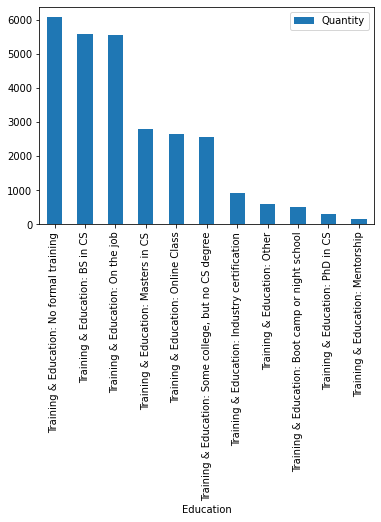

In [106]:
Count_educ_2015.set_index('Education', inplace=True)
Count_educ_2015.sort_values(by='Quantity', ascending=False).plot(kind='bar')

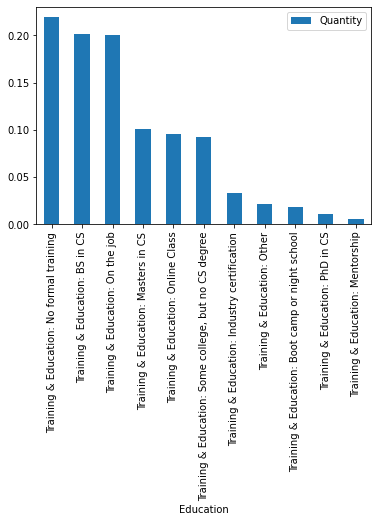

In [107]:
normalized_educ = Count_educ_2015 / Count_educ_2015.Quantity.sum()
normalized_educ.sort_values(by='Quantity', ascending=False).plot(kind='bar')

##**Analyzing the Data - 2015 x 2020**

**Average Salary 2015 x 2020**

In [108]:
#Average salary 2015

new_df2['Compensation: midpoint'].describe().to_frame()

,Compensation: midpoint
count,14818.000000
mean,51083.142124
std,44223.990391
min,0.000000
25%,10000.000000
50%,50000.000000
75%,70000.000000
max,170000.000000


In [109]:
avg_sal_2015 = new_df2['Compensation: midpoint'].describe().to_frame().loc['mean'][0]
print("{:.2f}".format(avg_sal_2015))

51083.14


In [112]:
#Average salary 2020

new_df['ConvertedComp'].describe().to_frame()

,ConvertedComp
count,30080.000000
mean,65653.821210
std,53456.919243
min,0.000000
25%,25944.000000
50%,54049.000000
75%,90000.000000
max,349043.000000


In [113]:
avg_sal_2020 = new_df['ConvertedComp'].describe().to_frame().loc['mean'][0]
print("{:.2f}".format(avg_sal_2020))

65653.82


In [114]:
Dif_avg_sal = avg_sal_2020 - avg_sal_2015
"The difference of average salary between 2015 and 2020 is: {:.2f}".format(Dif_avg_sal)

'The difference of average salary between 2015 and 2020 is: 14570.68'

In [115]:
"The salaries in 2020 are {:.2f} % higher in average.".format(Dif_avg_sal / avg_sal_2015 * 100)

'The salaries in 2020 are 28.52 % higher in average.'

**Education profile 2015 x 2020**

**2015**

In [117]:
normalized_educ = Count_educ_2015 / Count_educ_2015.Quantity.sum()
normalized_educ.sort_values(by='Quantity', ascending=False)

,Quantity
Education,
Training & Education: No formal training,0.219288
Training & Education: BS in CS,0.201753
Training & Education: On the job,0.200202
Training & Education: Masters in CS,0.100624
Training & Education: Online Class,0.095826
"Training & Education: Some college, but no CS degree",0.092218
Training & Education: Industry certification,0.033409
Training & Education: Other,0.021828
Training & Education: Boot camp or night school,0.018689


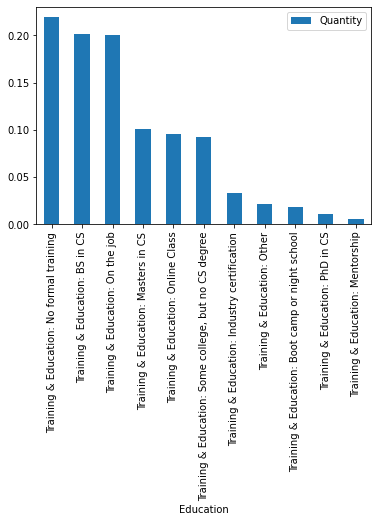

In [121]:
normalized_educ.sort_values(by='Quantity', ascending=False).plot(kind='bar')

**2020**

In [122]:
new_df['EdLevel'].value_counts(normalize=True).to_frame()

,EdLevel
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0.489328
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.257148
Some college/university study without earning a degree,0.119049
"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",0.044182
"Associate degree (A.A., A.S., etc.)",0.034707
"Other doctoral degree (Ph.D., Ed.D., etc.)",0.033610
"Professional degree (JD, MD, etc.)",0.013597
Primary/elementary school,0.004255
I never completed any formal education,0.004122


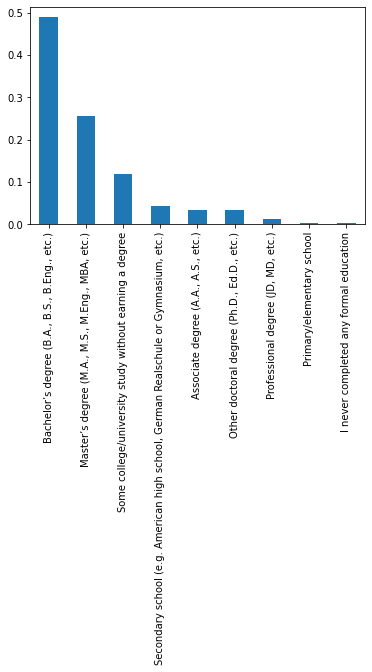

In [123]:
new_df['EdLevel'].value_counts(normalize=True).plot(kind='bar')

Analyzing the education profile, we can clearly see that formal education is much more present in 2020 than in 2015 - no formal education is in the top of the ranking in 2015. 

Adding only BS and MS from 2020 dataset, we have 75% of our sampling, whereas we have only 40% (adding college that is not in CS + BS in CS + MS) in 2015. 

**Salary by profile Education**

**2015**

In [124]:
educ_2015_list = list(normalized_educ.index)
educ_2015_list

['Training & Education: No formal training',
 'Training & Education: On the job',
 'Training & Education: Boot camp or night school',
 'Training & Education: Online Class',
 'Training & Education: Mentorship',
 'Training & Education: Industry certification',
 'Training & Education: Some college, but no CS degree',
 'Training & Education: BS in CS',
 'Training & Education: Masters in CS',
 'Training & Education: PhD in CS',
 'Training & Education: Other']

In [125]:
#Salary by Educ 2015

avg_sal_educ_2015 = {}

for col in educ_2015_list:
  col_total = list(new_df2.groupby([col])['Compensation: midpoint'].mean())[0]
  avg_sal_educ_2015[col] = col_total

In [126]:
avg_sal_educ_2015

{'Training & Education: BS in CS': 57249.64234620887,
 'Training & Education: Boot camp or night school': 63262.54826254826,
 'Training & Education: Industry certification': 67127.42980561555,
 'Training & Education: Masters in CS': 57490.13983506633,
 'Training & Education: Mentorship': 48092.10526315789,
 'Training & Education: No formal training': 44468.575189206975,
 'Training & Education: On the job': 56444.404397188686,
 'Training & Education: Online Class': 50542.1686746988,
 'Training & Education: Other': 47123.96694214876,
 'Training & Education: PhD in CS': 71993.24324324324,
 'Training & Education: Some college, but no CS degree': 47707.35524256651}

In [127]:
avg_sal_educ_2015_df = pd.DataFrame(list(avg_sal_educ_2015.items()),columns = ['Education','Avg Salary'])
avg_sal_educ_2015_df.sort_values(by='Avg Salary', ascending=False)

,Education,Avg Salary
9,Training & Education: PhD in CS,71993.243243
5,Training & Education: Industry certification,67127.429806
2,Training & Education: Boot camp or night school,63262.548263
8,Training & Education: Masters in CS,57490.139835
7,Training & Education: BS in CS,57249.642346
1,Training & Education: On the job,56444.404397
3,Training & Education: Online Class,50542.168675
4,Training & Education: Mentorship,48092.105263
6,"Training & Education: Some college, but no CS ...",47707.355243
10,Training & Education: Other,47123.966942


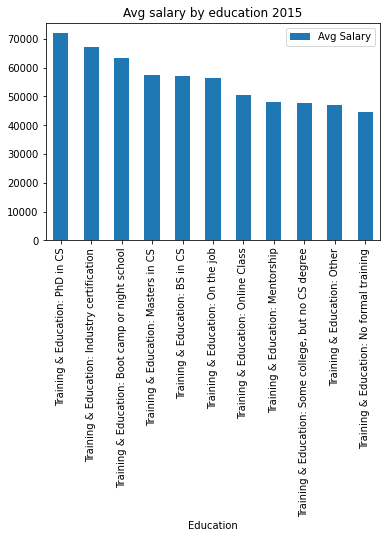

In [134]:
avg_sal_educ_2015_df.set_index('Education').sort_values(by='Avg Salary', ascending=False).plot(kind='bar', title='Avg salary by education 2015')

**2020**

In [128]:
new_df.groupby('EdLevel')['ConvertedComp'].mean().to_frame().sort_values(by='ConvertedComp', ascending=False)

,ConvertedComp
EdLevel,
"Other doctoral degree (Ph.D., Ed.D., etc.)",84285.905045
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",68045.608016
I never completed any formal education,65939.903226
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",65629.356818
"Associate degree (A.A., A.S., etc.)",65104.136015
Some college/university study without earning a degree,63069.324211
Primary/elementary school,62116.765625
"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",51662.425132
"Professional degree (JD, MD, etc.)",45759.867971


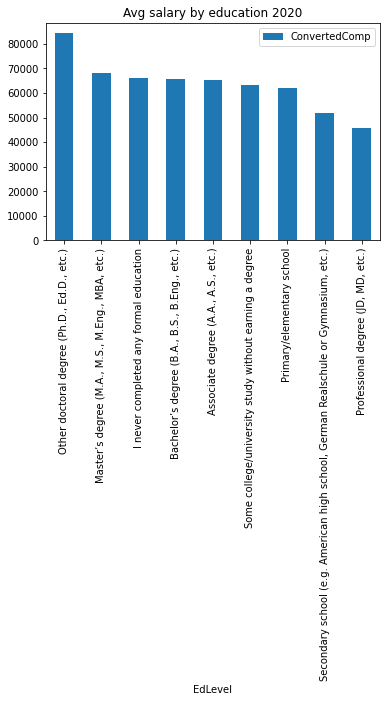

In [133]:
new_df.groupby('EdLevel')['ConvertedComp'].mean().to_frame().sort_values(by='ConvertedComp', ascending=False).plot(kind='bar', title='Avg salary by education 2020')

Since the average salary is higher in 2020, it is also reflected in the average salary by profile education. People with formal education earns higher salaries in the sampling of 2020, but it is very interesting to note that in 2015 no formal education like industry certification and Boot Camps or night school, earned also elevated salaries, only below PHD developers. 

**Age Profile 2015 x 2020**

**2015**

In [135]:
new_df2.Age.value_counts(normalize=True, dropna=True).to_frame()


,Age
25-29,0.283102
20-24,0.227561
30-34,0.190377
35-39,0.102578
40-50,0.086584
< 20,0.082467
51-60,0.020246
Prefer not to disclose,0.004656
> 60,0.002429


**2020**

In [136]:
label_ranges = [0, 19, 24, 29, 34, 39, 50, 60, np.inf]
label_names = ['<20', '20-24', '25-29', '30-34', '35-39','40-50', '51-60', '>60']

new_df['Age group'] = pd.cut(new_df['Age'], bins = label_ranges, labels = label_names)
new_df['Age group'].value_counts(normalize=True, dropna=True).to_frame()

,Age group
30-34,0.323404
25-29,0.262467
35-39,0.132746
20-24,0.130818
40-50,0.115426
51-60,0.028790
<20,0.006350
>60,0.000000


When it comes to compare the Age profile between 2015 and 2020, overall there is not that much difference, but we can note that it is getting a bit older in 2020.

**Salary by Age**

**2015**

In [137]:
new_df2.groupby('Age')['Compensation: midpoint'].mean().to_frame().sort_values(by='Compensation: midpoint', ascending=False)

,Compensation: midpoint
Age,
51-60,98866.666667
40-50,95003.897116
35-39,79355.263158
> 60,77777.777778
30-34,66313.364055
Prefer not to disclose,53043.478261
25-29,45930.870083
20-24,26705.219454
< 20,6972.176759


**2020**

In [138]:
new_df.groupby('Age group')['ConvertedComp'].mean().to_frame().sort_values(by='ConvertedComp', ascending=False)

,ConvertedComp
Age group,
51-60,104965.963048
40-50,92811.601382
35-39,83208.914100
30-34,67043.553043
25-29,53785.215959
20-24,37462.726048
<20,27337.973822
>60,NaN


When it comes to compare the range that can be found in both samplings, we note that the ranking of average salary by age does not change significantly.

**Years coding profile 2015 x 2020**

**2015**

In [139]:
new_df2['Years IT / Programming Experience'].value_counts(normalize=True, dropna=True).to_frame()

,Years IT / Programming Experience
2 - 5 years,0.318666
11+ years,0.265555
6 - 10 years,0.241261
1 - 2 years,0.121676
Less than 1 year,0.052841


**2020**

In [141]:
label_ranges2 = [0, 1, 2, 5, 10, np.inf]
label_names2 = ['0-1', '1-2', '2-5', '6-10', '>11']

new_df['years coding group'] = pd.cut(new_df['YearsCodePro'], bins = label_ranges2, labels = label_names2)
new_df['years coding group'].value_counts(normalize=True, dropna=True).to_frame()

,years coding group
>11,0.278856
2-5,0.270346
6-10,0.254388
1-2,0.099967
0-1,0.096443


**Salary by years coding**

**2015**

In [142]:
new_df2.groupby('Years IT / Programming Experience')['Compensation: midpoint'].mean().to_frame().sort_values(by='Compensation: midpoint', ascending=False)

,Compensation: midpoint
Years IT / Programming Experience,
11+ years,86424.396442
6 - 10 years,56688.111888
2 - 5 years,34487.505294
1 - 2 years,21447.587354
Less than 1 year,16206.896552


**2020**

In [143]:
new_df.groupby('years coding group')['ConvertedComp'].mean().to_frame().sort_values(by='ConvertedComp', ascending=False)

,ConvertedComp
years coding group,
>11,93411.716261
6-10,70010.699948
2-5,52793.476513
1-2,40487.825075
0-1,36037.279903


Comparing both samplings we do not see difference in the ranking, as expected, since higher is years of experience, the more we expect a higher salary. The only difference is in the salary in average for every group (higher for 2020).

##**Using a linear regression model including only the variables we separed previously, let's check which one is the most important in terms of affecting salaries**

**2015**

Since the dataframe of 2015 survey has its numeric variables separated into groups, we are going to get their midpoint and transform them into int numbers 

Obs: it is important to note that we are doing this as a simple analysis, in order to create a more efficient model to predict the salaries, we'd better analyze other points

In [146]:
#Age data of 2015

new_df2['Age'].value_counts()

25-29    4195
20-24    3372
30-34    2821
35-39    1520
40-50    1283
< 20     1222
51-60     300
> 60       36
Name: Age, dtype: int64

In [148]:
#Eliminating 'prefer not to disclose'

new_df2 = new_df2[new_df2['Age'] != 'Prefer not to disclose']
new_df2['Age'].value_counts()

25-29    4195
20-24    3372
30-34    2821
35-39    1520
40-50    1283
< 20     1222
51-60     300
> 60       36
Name: Age, dtype: int64

In [149]:
#Transforming to numerical and int data

def label_age (row):
  if row['Age'] == '25-29' :
    return '27'
  if row['Age'] == '30-34' :
    return '32'
  if row['Age'] == '20-24' :
    return '22'
  if row['Age'] == '35-39' :
    return '37'
  if row['Age'] == '40-50' :
    return '45'
  if row['Age'] == '51-60' :
    return '56'
  if row['Age'] == '< 20' :
    return '18'
  if row['Age'] == '> 60' :
    return '60'

In [150]:
new_df2['Age_midpoint'] = new_df2.apply (lambda row: label_age(row), axis=1)
new_df2.head()

,Country,Age,Years IT / Programming Experience,Compensation: midpoint,Training & Education: No formal training,Training & Education: On the job,Training & Education: Boot camp or night school,Training & Education: Online Class,Training & Education: Mentorship,Training & Education: Industry certification,"Training & Education: Some college, but no CS degree",Training & Education: BS in CS,Training & Education: Masters in CS,Training & Education: PhD in CS,Training & Education: Other,Age_midpoint
1,France,20-24,1 - 2 years,30000,NaN,NaN,NaN,"Online class (ie. Coursera, Codecademy, Khan A...",NaN,Industry certification program,NaN,NaN,Masters Degree in Computer Science (or related...,NaN,NaN,22
2,India,20-24,1 - 2 years,90000,NaN,NaN,NaN,NaN,"Mentorship program (ie. Flatiron School, GDI, ...",NaN,NaN,NaN,NaN,NaN,NaN,22
4,Norway,30-34,2 - 5 years,70000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bachelor of Science in Computer Science (or re...,NaN,NaN,NaN,32
7,Argentina,25-29,6 - 10 years,70000,NaN,On-the-job training,NaN,"Online class (ie. Coursera, Codecademy, Khan A...",NaN,NaN,NaN,Bachelor of Science in Computer Science (or re...,Masters Degree in Computer Science (or related...,NaN,NaN,27
11,Belgium,25-29,2 - 5 years,30000,NaN,On-the-job training,NaN,"Online class (ie. Coursera, Codecademy, Khan A...",NaN,NaN,NaN,Bachelor of Science in Computer Science (or re...,NaN,NaN,NaN,27


In [152]:
#Dealing with years of experience

new_df2['Years IT / Programming Experience'].value_counts()

2 - 5 years         4704
11+ years           3914
6 - 10 years        3565
1 - 2 years         1789
Less than 1 year     777
Name: Years IT / Programming Experience, dtype: int64

In [153]:
def label_yearscod (row):
  if row['Years IT / Programming Experience'] == '11+ years' :
    return '11'
  if row['Years IT / Programming Experience'] == '2 - 5 years' :
    return '4'
  if row['Years IT / Programming Experience'] == '6 - 10 years' :
    return '8'
  if row['Years IT / Programming Experience'] == '1 - 2 years' :
    return '2'
  if row['Years IT / Programming Experience'] == 'Less than 1 year' :
    return '1'

In [154]:
new_df2['yearscod_midpoint'] = new_df2.apply (lambda row: label_yearscod(row), axis=1)
new_df2.head()

,Country,Age,Years IT / Programming Experience,Compensation: midpoint,Training & Education: No formal training,Training & Education: On the job,Training & Education: Boot camp or night school,Training & Education: Online Class,Training & Education: Mentorship,Training & Education: Industry certification,"Training & Education: Some college, but no CS degree",Training & Education: BS in CS,Training & Education: Masters in CS,Training & Education: PhD in CS,Training & Education: Other,Age_midpoint,yearscod_midpoint
1,France,20-24,1 - 2 years,30000,NaN,NaN,NaN,"Online class (ie. Coursera, Codecademy, Khan A...",NaN,Industry certification program,NaN,NaN,Masters Degree in Computer Science (or related...,NaN,NaN,22,2
2,India,20-24,1 - 2 years,90000,NaN,NaN,NaN,NaN,"Mentorship program (ie. Flatiron School, GDI, ...",NaN,NaN,NaN,NaN,NaN,NaN,22,2
4,Norway,30-34,2 - 5 years,70000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bachelor of Science in Computer Science (or re...,NaN,NaN,NaN,32,4
7,Argentina,25-29,6 - 10 years,70000,NaN,On-the-job training,NaN,"Online class (ie. Coursera, Codecademy, Khan A...",NaN,NaN,NaN,Bachelor of Science in Computer Science (or re...,Masters Degree in Computer Science (or related...,NaN,NaN,27,8
11,Belgium,25-29,2 - 5 years,30000,NaN,On-the-job training,NaN,"Online class (ie. Coursera, Codecademy, Khan A...",NaN,NaN,NaN,Bachelor of Science in Computer Science (or re...,NaN,NaN,NaN,27,4


In [156]:
new_df2['yearscod_midpoint'] = new_df2['yearscod_midpoint'].astype('int')
new_df2['Age_midpoint'] = new_df2['Age_midpoint'].astype('int')
new_df2.describe()

,Compensation: midpoint,Age_midpoint,yearscod_midpoint
count,14749.000000,14749.000000,14749.000000
mean,51073.971117,29.334328,6.423825
std,44154.956432,8.367712,3.457731
min,0.000000,18.000000,1.000000
25%,10000.000000,22.000000,4.000000
50%,50000.000000,27.000000,8.000000
75%,70000.000000,32.000000,11.000000
max,170000.000000,60.000000,11.000000


In [157]:
#Working with categorical variables

new_df2_cat = pd.get_dummies(new_df2[['Training & Education: No formal training',
       'Training & Education: On the job',
       'Training & Education: Boot camp or night school',
       'Training & Education: Online Class',
       'Training & Education: Mentorship',
       'Training & Education: Industry certification',
       'Training & Education: Some college, but no CS degree',
       'Training & Education: BS in CS', 'Training & Education: Masters in CS',
       'Training & Education: PhD in CS', 'Training & Education: Other']])

In [158]:
new_df2_cat2 = pd.get_dummies(new_df2['Country'], drop_first=True)

In [159]:
X = pd.concat([new_df2[['yearscod_midpoint', 'Age_midpoint']], new_df2_cat, new_df2_cat2], axis=1)
y = new_df2['Compensation: midpoint']

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

In [162]:
#Apply a linear regression model

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

y_test_preds = lm_model.predict(X_test) 

print(r2_score(y_test, y_test_preds))

0.5517128475053994


In [163]:
#Function to analyze the coefs that affects the salary the most

def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [166]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
41,Switzerland,53558.069338,53558.069338
45,United States,51810.571930,51810.571930
13,Australia,45546.489698,45546.489698
34,Norway,45021.522245,45021.522245
20,Denmark,39368.581940,39368.581940
29,Israel,36885.007326,36885.007326
17,Canada,36088.479582,36088.479582
44,United Kingdom,35562.229294,35562.229294
28,Ireland {Republic},30334.974673,30334.974673
33,New Zealand,29627.334385,29627.334385


**2020**

In [167]:
#working with categorical

new_df_cat = pd.get_dummies(new_df[['EdLevel','Country']], drop_first=True)

In [168]:
X = pd.concat([new_df[['Age', 'YearsCodePro']], new_df_cat], axis=1)
y = new_df['ConvertedComp']

In [169]:
#Apply linear regression model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

y_test_preds = lm_model.predict(X_test) 

print(r2_score(y_test, y_test_preds))

0.5356370326635582


In [172]:
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
58,Country_United States,90162.760167,90162.760167
54,Country_Switzerland,75653.527121,75653.527121
32,Country_Israel,70723.666290,70723.666290
21,Country_Denmark,56468.487280,56468.487280
31,Country_Ireland,52247.828422,52247.828422
40,Country_Norway,51755.121593,51755.121593
10,Country_Australia,49957.385050,49957.385050
57,Country_United Kingdom,47587.109654,47587.109654
16,Country_Canada,44560.170399,44560.170399
48,Country_Singapore,43086.719640,43086.719640


Looking into this comparison, coefficients from 2015 and 2020, we can note that Country was the most important variable to influence the salaries - **according to the variables chosen in this model.**

Obs.: It is important to remember once more that our focus here is not to create the best model to predict salaries. We should analyze other factors if this was the case. For example, Age and years coding are very correlated variables, and we could eliminate one of them, but we decided to keep both since, as mentioned, the focus is not create a model to predict salaries, but rather compare 2015 data with 2020.  